In [ ]:
!nvidia-smi

Thu Apr 20 10:23:33 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Install TensorFlow and TensorFlow Model Garden

In [ ]:
import tensorflow as tf
print(tf.version.VERSION)

2.12.0


In [ ]:
#!pip install -q tensorflow==2.3.0

In [ ]:
!git clone --depth 1 -b v2.3.0 https://github.com/tensorflow/models.git

fatal: destination path 'models' already exists and is not an empty directory.


In [ ]:
# install requirements to use tensorflow/models repository
!pip install -Uqr models/official/requirements.txt
# you may have to restart the runtime afterwards

  Preparing metadata (setup.py) ... done
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.12.0 requires numpy<1.24,>=1.22, but you have numpy 1.24.2 which is incompatible.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.24.2 which is incompatible.
google-colab 1.0.0 requires pandas~=1.5.3, but you have pandas 2.0.0 which is incompatible.


In [ ]:
!pip install tensorflow-text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached numpy-1.23.5-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.1 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.2
    Uninstalling numpy-1.24.2:
      Successfully uninstalled numpy-1.24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas~=1.5.3, but you have pandas 2.0.0 which is incompatible.


In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import sys
sys.path.append('models')
from official.nlp.data import classifier_data_lib
from official.nlp.bert import tokenization
from official.nlp import optimization
import tensorflow_text as text
import pandas as pd
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout, Bidirectional, LSTM
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Embedding, LSTM, Dense ## Neural networks layers
from tensorflow.keras import layers
from keras import regularizers
import re
import warnings; warnings.simplefilter('ignore')
import tqdm


/usr/local/lib/python3.9/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
print("TF Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

TF Version:  2.12.0
Eager mode:  True
Hub version:  0.13.0
GPU is available


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('always')

In [ ]:
df_train = pd.read_csv('/content/propaganda_train.tsv',sep='\t')
df_train

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,label,tagged_in_context
0,not_propaganda,"No, <BOS> he <EOS> will not be confirmed."
1,not_propaganda,This declassification effort <BOS> won’t make ...
2,flag_waving,The Obama administration misled the <BOS> Amer...
3,not_propaganda,“It looks like we’re capturing the demise of t...
4,not_propaganda,"<BOS> Location: Westerville, Ohio <EOS>"
...,...,...
2409,not_propaganda,<BOS> We support and appreciate <EOS> your bus...
2410,not_propaganda,International Atomic Energy Agency (IAEA) Dire...
2411,not_propaganda,What has been done: there has been work on for...
2412,not_propaganda,This is <BOS> the law of gradualness not the g...


In [ ]:
df_train['label'].unique()

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array(['not_propaganda', 'flag_waving', 'loaded_language', 'doubt',
       'name_calling,labeling', 'appeal_to_fear_prejudice', 'repetition',
       'causal_oversimplification', 'exaggeration,minimisation'],
      dtype=object)

In [ ]:
def get_label_data(tagged_in_context):
     label_data=[]
     for i in tagged_in_context:
          m=re.search('<BOS>(.+?)<EOS>', i)
          found = m.group(1)
          label_data.append(found)
     return label_data

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
label_data_train=get_label_data(df_train.tagged_in_context)
df_train['label_data']=label_data_train

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
df_train

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,label,tagged_in_context,label_data
0,not_propaganda,"No, <BOS> he <EOS> will not be confirmed.",he
1,not_propaganda,This declassification effort <BOS> won’t make ...,won’t make things any worse than they are for...
2,flag_waving,The Obama administration misled the <BOS> Amer...,American people
3,not_propaganda,“It looks like we’re capturing the demise of t...,and
4,not_propaganda,"<BOS> Location: Westerville, Ohio <EOS>","Location: Westerville, Ohio"
...,...,...,...
2409,not_propaganda,<BOS> We support and appreciate <EOS> your bus...,We support and appreciate
2410,not_propaganda,International Atomic Energy Agency (IAEA) Dire...,capacity to check whether Iran was conducting...
2411,not_propaganda,What has been done: there has been work on for...,one for those recently
2412,not_propaganda,This is <BOS> the law of gradualness not the g...,the law of gradualness not the gradualness of...


In [ ]:
df_train['multi_label'] = pd.Categorical(df_train['label']).codes


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
df_train

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,label,tagged_in_context,label_data,multi_label
0,not_propaganda,"No, <BOS> he <EOS> will not be confirmed.",he,7
1,not_propaganda,This declassification effort <BOS> won’t make ...,won’t make things any worse than they are for...,7
2,flag_waving,The Obama administration misled the <BOS> Amer...,American people,4
3,not_propaganda,“It looks like we’re capturing the demise of t...,and,7
4,not_propaganda,"<BOS> Location: Westerville, Ohio <EOS>","Location: Westerville, Ohio",7
...,...,...,...,...
2409,not_propaganda,<BOS> We support and appreciate <EOS> your bus...,We support and appreciate,7
2410,not_propaganda,International Atomic Energy Agency (IAEA) Dire...,capacity to check whether Iran was conducting...,7
2411,not_propaganda,What has been done: there has been work on for...,one for those recently,7
2412,not_propaganda,This is <BOS> the law of gradualness not the g...,the law of gradualness not the gradualness of...,7


In [ ]:
df_test=pd.read_csv('/content/propaganda_val.tsv',sep='\t')
df_test

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,label,tagged_in_context
0,not_propaganda,"On average, between 300 and 600 infections are..."
1,causal_oversimplification,Mostly because <BOS> the country would not las...
2,appeal_to_fear_prejudice,Lyndon Johnson <BOS> gets Earl Warren and Sen....
3,not_propaganda,<BOS> You <EOS> may opt out at anytime.
4,repetition,It must be exacted from him directly in order ...
...,...,...
575,not_propaganda,"NewsCatholic Church, <BOS> Family, Marriage <E..."
576,not_propaganda,"Remember our saying, modern day fairy <BOS> ta..."
577,not_propaganda,Why <BOS> not <EOS> open up to Iran with massi...
578,flag_waving,<BOS> He also sang an Islamic State fight song...


In [ ]:
label_data_test=get_label_data(df_test.tagged_in_context)
df_test['label_data']=label_data_test

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
df_test

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,label,tagged_in_context,label_data
0,not_propaganda,"On average, between 300 and 600 infections are...",according to a UN estimate.
1,causal_oversimplification,Mostly because <BOS> the country would not las...,the country would not last long without an ou...
2,appeal_to_fear_prejudice,Lyndon Johnson <BOS> gets Earl Warren and Sen....,gets Earl Warren and Sen. Richard Russel to j...
3,not_propaganda,<BOS> You <EOS> may opt out at anytime.,You
4,repetition,It must be exacted from him directly in order ...,infidels
...,...,...,...
575,not_propaganda,"NewsCatholic Church, <BOS> Family, Marriage <E...","Family, Marriage"
576,not_propaganda,"Remember our saying, modern day fairy <BOS> ta...",tales start with ‘once I am
577,not_propaganda,Why <BOS> not <EOS> open up to Iran with massi...,not
578,flag_waving,<BOS> He also sang an Islamic State fight song...,He also sang an Islamic State fight song and ...


In [ ]:
df_test['multi_label'] = pd.Categorical(df_test['label']).codes


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
df_test

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,label,tagged_in_context,label_data,multi_label
0,not_propaganda,"On average, between 300 and 600 infections are...",according to a UN estimate.,7
1,causal_oversimplification,Mostly because <BOS> the country would not las...,the country would not last long without an ou...,1
2,appeal_to_fear_prejudice,Lyndon Johnson <BOS> gets Earl Warren and Sen....,gets Earl Warren and Sen. Richard Russel to j...,0
3,not_propaganda,<BOS> You <EOS> may opt out at anytime.,You,7
4,repetition,It must be exacted from him directly in order ...,infidels,8
...,...,...,...,...
575,not_propaganda,"NewsCatholic Church, <BOS> Family, Marriage <E...","Family, Marriage",7
576,not_propaganda,"Remember our saying, modern day fairy <BOS> ta...",tales start with ‘once I am,7
577,not_propaganda,Why <BOS> not <EOS> open up to Iran with massi...,not,7
578,flag_waving,<BOS> He also sang an Islamic State fight song...,He also sang an Islamic State fight song and ...,4


In [ ]:
df_train['label']=df_train['label'].apply(lambda x: 1 if x=='not_propaganda' else 0)
df_train.head()

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,label,tagged_in_context,label_data,multi_label
0,1,"No, <BOS> he <EOS> will not be confirmed.",he,7
1,1,This declassification effort <BOS> won’t make ...,won’t make things any worse than they are for...,7
2,0,The Obama administration misled the <BOS> Amer...,American people,4
3,1,“It looks like we’re capturing the demise of t...,and,7
4,1,"<BOS> Location: Westerville, Ohio <EOS>","Location: Westerville, Ohio",7


In [ ]:
df_test['label']=df_test['label'].apply(lambda x: 1 if x=='not_propaganda' else 0)
df_test.head()

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,label,tagged_in_context,label_data,multi_label
0,1,"On average, between 300 and 600 infections are...",according to a UN estimate.,7
1,0,Mostly because <BOS> the country would not las...,the country would not last long without an ou...,1
2,0,Lyndon Johnson <BOS> gets Earl Warren and Sen....,gets Earl Warren and Sen. Richard Russel to j...,0
3,1,<BOS> You <EOS> may opt out at anytime.,You,7
4,0,It must be exacted from him directly in order ...,infidels,8


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Axes: title={'center': 'Target Distribution'}, ylabel='Frequency'>

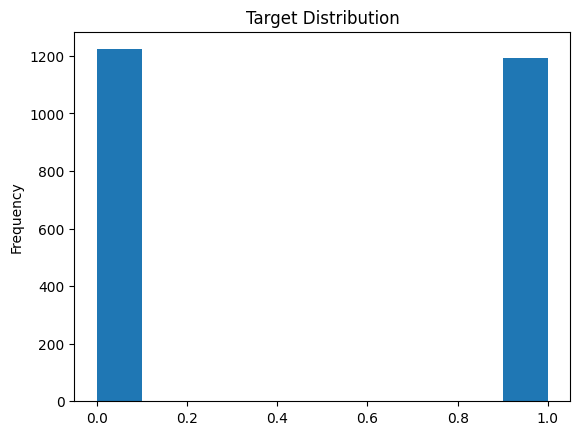

In [ ]:
# target label distribution
df_train.label.plot(kind='hist', title="Target Distribution")

In [ ]:
df_train1=df_train.loc[df_train['label']==0]

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Axes: title={'center': 'Target Distribution'}, ylabel='Frequency'>

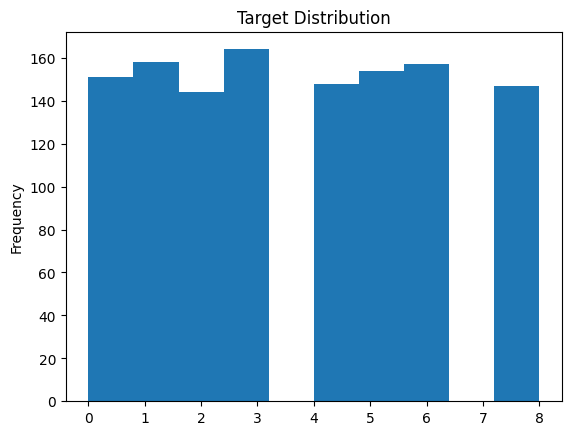

In [ ]:
df_train1.multi_label.plot(kind='hist', title="Target Distribution")

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Axes: title={'center': 'Target Distribution'}, ylabel='Frequency'>

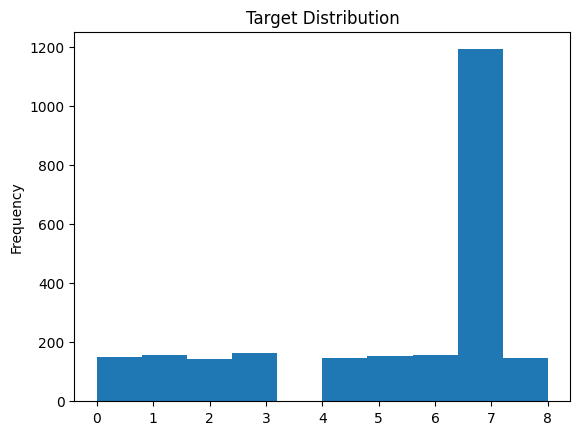

In [ ]:
df_train.multi_label.plot(kind='hist', title="Target Distribution")

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Axes: title={'center': 'Target Distribution'}, ylabel='Frequency'>

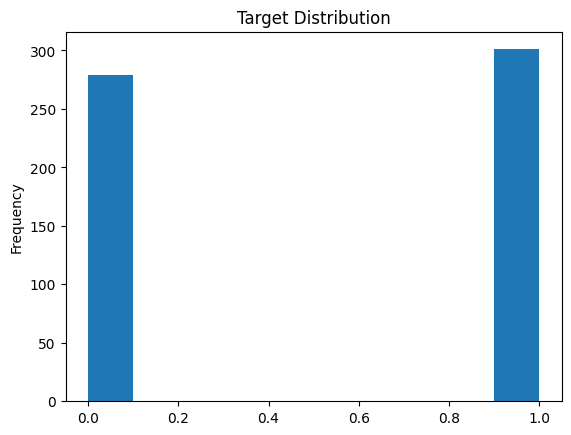

In [ ]:
df_test.label.plot(kind='hist', title="Target Distribution")

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Axes: title={'center': 'Target Distribution'}, ylabel='Frequency'>

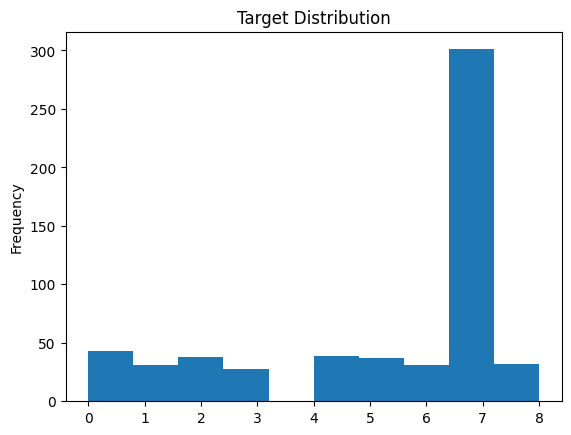

In [ ]:
df_test.multi_label.plot(kind='hist', title="Target Distribution")

In [ ]:
df_test1=df_test.loc[df_test['label']==0]

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
df_test1

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,label,tagged_in_context,label_data,multi_label
1,0,Mostly because <BOS> the country would not las...,the country would not last long without an ou...,1
2,0,Lyndon Johnson <BOS> gets Earl Warren and Sen....,gets Earl Warren and Sen. Richard Russel to j...,0
4,0,It must be exacted from him directly in order ...,infidels,8
5,0,Is it any wonder that priests and laity alike ...,"the ""gay lifestyle",6
6,0,Health workers have been asked to work with co...,devastating communities,5
...,...,...,...,...
569,0,"As a result, 58,177 <BOS> Americans <EOS> woul...",Americans,4
571,0,<BOS> But if you are a freedom-loving American...,But if you are a freedom-loving American,4
572,0,I heard lots of <BOS> gut-wrenching stories <E...,gut-wrenching stories,5
578,0,<BOS> He also sang an Islamic State fight song...,He also sang an Islamic State fight song and ...,4


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Axes: title={'center': 'Target Distribution'}, ylabel='Frequency'>

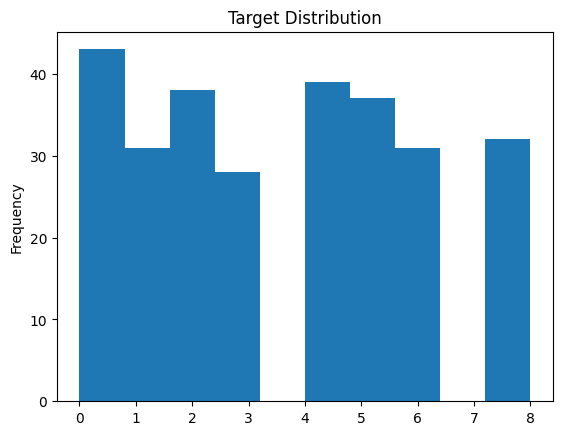

In [ ]:
df_test1.multi_label.plot(kind='hist', title="Target Distribution")

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Create tf.data.Datasets for Training and Evaluation

We will be working with only a small portion of data since the data is huge and finetuning the bert model and that big size would considerabely take large amount of time.

In [ ]:
train_df= df_train
val_df, test_df = train_test_split(df_test, random_state=42, train_size = 0.70, stratify = df_test['label'])

print(train_df.shape, val_df.shape)

(2414, 4) (406, 4)


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
test_df

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,label,tagged_in_context,label_data,multi_label
486,1,Ed Pentin has a long file of interviews and ar...,that clearly show his complete inability to m...,7
291,1,To <BOS> achieve that and hold onto power the ...,achieve that and hold onto power the prime mi...,7
2,0,Lyndon Johnson <BOS> gets Earl Warren and Sen....,gets Earl Warren and Sen. Richard Russel to j...,0
165,0,"<BOS> In a nation guided by fairness and law, ...","In a nation guided by fairness and law, a per...",4
128,0,"<BOS> Of course, we know what Obama did with h...","Of course, we know what Obama did with his da...",2
...,...,...,...,...
205,0,There is no low to which the Democrats will no...,strengthening America and protecting Americans,4
207,1,|Patrick <BOS> J. <EOS> Buchanan: Boehner's Ri...,J.,7
373,1,The insults were not <BOS> forgotten. <EOS>,forgotten.,7
213,0,"And now <BOS> she has gone full rogue <EOS>, p...",she has gone full rogue,5


In [ ]:
with tf.device('/cpu:0'):
  train_data = tf.data.Dataset.from_tensor_slices((train_df['tagged_in_context'].values, train_df['label'].values))
  val_data = tf.data.Dataset.from_tensor_slices((val_df['tagged_in_context'].values, val_df['label'].values))

  for text, label in train_data.take(1):
    print(text)
    print(label)

tf.Tensor(b'No, <BOS> he <EOS> will not be confirmed. ', shape=(), dtype=string)
tf.Tensor(1, shape=(), dtype=int64)


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Pretrainted BERT Model


### Download a Pre-trained BERT Model from TensorFlow Hub

In [ ]:
"""
Each line of the dataset is composed of the review text and its label
- Data preprocessing consists of transforming text to BERT input features:
input_word_ids, input_mask, segment_ids
- In the process, tokenizing the text is done with the provided BERT model tokenizer
"""

# Label categories
label_list = [0, 1]

# maximum length of (token) input sequences
max_seq_length = 128  # default max length

train_batch_size = 32



/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Get BERT layer and tokenizer
bert_layer = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'
tokenizer = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# create keras layers to preprocess the text and encode to fit to the bert model

text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name = 'inputs')

# preprocessing
preprocessor = hub.KerasLayer(tokenizer)
encoder_inputs = preprocessor(text_input)

preprocess_model = tf.keras.Model(text_input, encoder_inputs)



/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Create a TensorFlow Input Pipeline with `tf.data`

In [ ]:
with tf.device('/cpu:0'):
  # train
  train_data = train_data.shuffle(1000).batch(32, drop_remainder = True).prefetch(tf.data.experimental.AUTOTUNE)

  # valid
  val_data = val_data.batch(32, drop_remainder = True).prefetch(tf.data.experimental.AUTOTUNE)


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# train data spec
train_data.element_spec

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(TensorSpec(shape=(32,), dtype=tf.string, name=None),
 TensorSpec(shape=(32,), dtype=tf.int64, name=None))

In [ ]:
# valid data spec
val_data.element_spec

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(TensorSpec(shape=(32,), dtype=tf.string, name=None),
 TensorSpec(shape=(32,), dtype=tf.int64, name=None))

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## First Task Model #1


Build and evaluate at least 2 approaches to classify whether a sentence contains propaganda or not.

### Add a Classification Head to the BERT Layer

In [ ]:
# Building the model
def create_model():

  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name = 'inputs')

  # preprocessing
  preprocessor = hub.KerasLayer(tokenizer)
  encoder_inputs = preprocessor(text_input)

  # passing the encoded inputs to bert model
  encoder = hub.KerasLayer(bert_layer, trainable=True, name = 'BERT_Encoder')
  outputs = encoder(encoder_inputs)

  # get the pooled outputs
  pooled_output = outputs['pooled_output']

  # add output layer
  batch_norm = tf.keras.layers.BatchNormalization()(pooled_output)
  drop = tf.keras.layers.Dropout(0.4)(batch_norm)
  fc = tf.keras.layers.Dense(128, activation='relu')(drop)
  final_output = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier')(fc)

  return tf.keras.Model(text_input, final_output)


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Fine-Tune BERT for Text Classification

In [ ]:
model = create_model()
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss = tf.keras.losses.BinaryCrossentropy(),
              metrics = [tf.keras.metrics.BinaryAccuracy()])

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None,)]            0           []                               
                                                                                                  
 keras_layer_1 (KerasLayer)     {'input_type_ids':   0           ['inputs[0][0]']                 
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128)}                                                

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Train model
epochs = 4
history = model.fit(train_data,
                    validation_data=val_data,
                    epochs=epochs,
                    verbose=1)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Epoch 1/4
75/75 [==============================] - 132s 920ms/step - loss: 0.6188 - binary_accuracy: 0.6762 - val_loss: 0.5381 - val_binary_accuracy: 0.7734
Epoch 2/4
75/75 [==============================] - 70s 933ms/step - loss: 0.3263 - binary_accuracy: 0.8612 - val_loss: 0.3373 - val_binary_accuracy: 0.8854
Epoch 3/4
75/75 [==============================] - 70s 935ms/step - loss: 0.1526 - binary_accuracy: 0.9417 - val_loss: 0.2427 - val_binary_accuracy: 0.9167
Epoch 4/4
75/75 [==============================] - 70s 932ms/step - loss: 0.0818 - binary_accuracy: 0.9708 - val_loss: 0.2523 - val_binary_accuracy: 0.9062


### *Evaluate* the BERT Text Classification Model

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


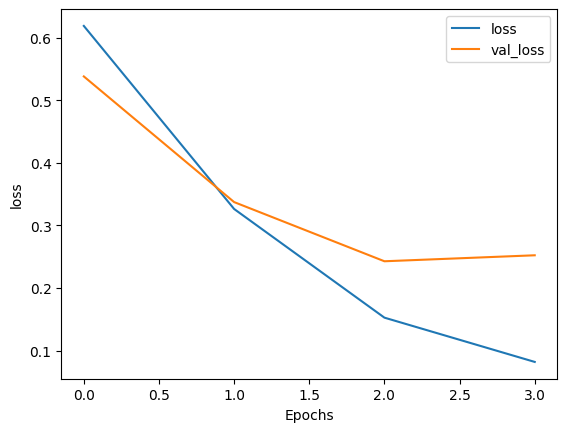

In [ ]:
plot_graphs(history=history, metric='loss')

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


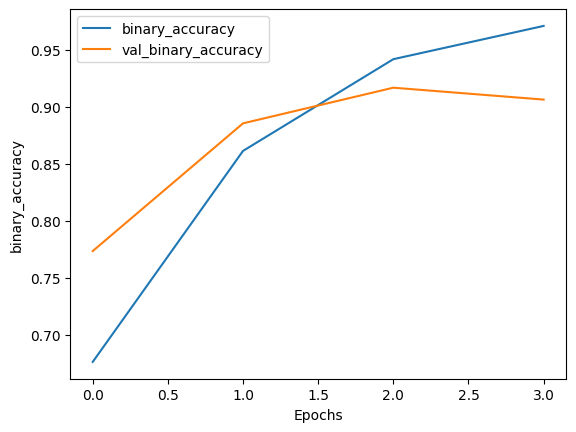

In [ ]:
plot_graphs(history,'binary_accuracy')

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# testing on some samples
sample_example = ["We’ll stop <BOS> it,” <EOS> Strzok responded."]
model.predict(sample_example)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


1/1 [==============================] - 1s 830ms/step


array([[0.8970381]], dtype=float32)

In [ ]:
sample_example = ["Trump To Jeff Sessions: Put An End to Russia Probe - <BOS> Prosecutors Doing Mueller’s ‘Dirty Work Are A Disgrace’ To America <EOS>"]
model.predict(sample_example)

1/1 [==============================] - 0s 47ms/step


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([[0.01144329]], dtype=float32)

In [ ]:
test=test_df.tagged_in_context

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
prediction=model.predict(test)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


6/6 [==============================] - 3s 334ms/step


In [ ]:
test_label=test_df.label

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
pred=[1 if i>0.5 else 0 for i in prediction]

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(test_label, pred))

              precision    recall  f1-score   support

           0       0.86      0.98      0.92        84
           1       0.97      0.86      0.91        90

    accuracy                           0.91       174
   macro avg       0.92      0.92      0.91       174
weighted avg       0.92      0.91      0.91       174



/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


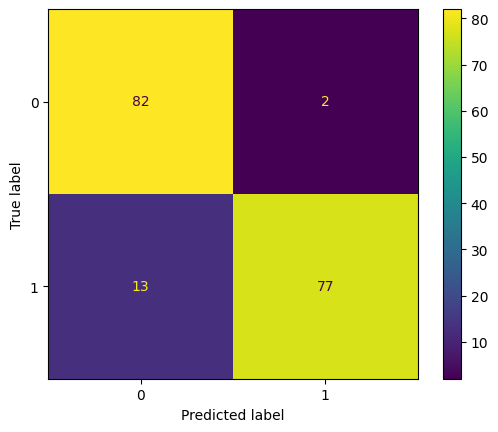

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(test_label, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Second Task Model #1



Given a snippet or span of text which is known to contain propaganda, build and evaluate at least
2 approaches to classifying the propaganda technique which has been used.

In [ ]:
train_df1=train_df.loc[train_df['label']==0]
train_df1

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,label,tagged_in_context,label_data,multi_label
2,0,The Obama administration misled the <BOS> Amer...,American people,4
5,0,"Hitler <BOS> annihilated <EOS> 400,000 Germans...",annihilated,5
8,0,"As noted above, at this point literally every ...",so-called evidence,2
10,0,His account was suspended for violating Twitte...,hateful conduct,6
12,0,A couple of seemingly unrelated events this pa...,point to Iran’s positioning itself for more a...,0
...,...,...,...,...
2403,0,You might think that would have cured him of f...,Nazi,8
2405,0,“I would like to take this opportunity to make...,absolutely no place for anti-Semitism,3
2406,0,Trump To Jeff Sessions: Put An End to Russia P...,Prosecutors Doing Mueller’s ‘Dirty Work Are A...,4
2407,0,<BOS> Neither the Democrat leadership nor the ...,Neither the Democrat leadership nor the Democ...,1


In [ ]:
val_df1 =val_df.loc[val_df['label']==0]
val_df1

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,label,tagged_in_context,label_data,multi_label
335,0,In analyzing the highly anticipated OIG report...,emerged in a disappointingly watered-down form,2
356,0,"JStreetPAC, the arm of the NGO that funds and ...",virulently anti-Semitic,5
345,0,This is starting to look more and more like <B...,a gun running operation gone wrong every day,8
232,0,REMNANT COMMENT: While we certainly appreciate...,horrific scandal,5
77,0,<BOS> The American people are not going to put...,The American people are not going to put up w...,4
...,...,...,...,...
9,0,"<BOS> Now, the pope’s reply to my testimony wa...","Now, the pope’s reply to my testimony was: “I...",2
542,0,"<BOS> Similarly, the Guardian worked tirelessl...","Similarly, the Guardian worked tirelessly to ...",2
492,0,On both of their blogs the pair called their b...,a striking blow against freedom,5
1,0,Mostly because <BOS> the country would not las...,the country would not last long without an ou...,1


In [ ]:
with tf.device('/cpu:0'):
  train_data = tf.data.Dataset.from_tensor_slices((train_df1['tagged_in_context'].values, train_df1['multi_label'].values))
  val_data = tf.data.Dataset.from_tensor_slices((val_df1['tagged_in_context'].values, val_df1['multi_label'].values))

  for text, label in train_data.take(1):
    print(text)
    print(label)

tf.Tensor(b'The Obama administration misled the <BOS> American people <EOS> and Congress because they were desperate to get a deal with Iran, said Sen. ', shape=(), dtype=string)
tf.Tensor(4, shape=(), dtype=int8)


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:

# Label categories
label_list = [0,1,2,3,4,5,6,8]

# maximum length of (token) input sequences
max_seq_length = 128  # default max length

train_batch_size = 32


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:

text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name = 'inputs')

# preprocessing
preprocessor = hub.KerasLayer(tokenizer)
encoder_inputs = preprocessor(text_input)

preprocess_model = tf.keras.Model(text_input, encoder_inputs)



/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
with tf.device('/cpu:0'):
  # train
  train_data = train_data.shuffle(1000).batch(32, drop_remainder = True).prefetch(tf.data.experimental.AUTOTUNE)

  # valid
  val_data = val_data.batch(32, drop_remainder = True).prefetch(tf.data.experimental.AUTOTUNE)


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def create_model():

  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name = 'inputs')

  # preprocessing
  preprocessor = hub.KerasLayer(tokenizer)
  encoder_inputs = preprocessor(text_input)

  # passing the encoded inputs to bert model
  encoder = hub.KerasLayer(bert_layer, trainable=True, name = 'BERT_Encoder')
  outputs = encoder(encoder_inputs)

  # get the pooled outputs
  pooled_output = outputs['pooled_output']

  # add output layer and because it is multiclassification so we need to get 9 possible outcomes.
  batch_norm = tf.keras.layers.BatchNormalization()(pooled_output)
  drop = tf.keras.layers.Dropout(0.4)(batch_norm)
  fc = tf.keras.layers.Dense(128, activation='relu')(drop)
  final_output = tf.keras.layers.Dense(9, activation='softmax', name='classifier')(fc)

  return tf.keras.Model(text_input, final_output)


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# for loss we used sparse_categorical_crossentropy because of multiclassification.
model = create_model()
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss = 'sparse_categorical_crossentropy',
              metrics = 'accuracy')

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Train model
epochs = 8
history = model.fit(train_data,
                    validation_data=val_data,
                    epochs=epochs,
                    verbose=1)

Epoch 1/8


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


38/38 [==============================] - 85s 969ms/step - loss: 2.5529 - accuracy: 0.1217 - val_loss: 2.2113 - val_accuracy: 0.1406
Epoch 2/8
38/38 [==============================] - 36s 948ms/step - loss: 2.1259 - accuracy: 0.2188 - val_loss: 2.1547 - val_accuracy: 0.1406
Epoch 3/8
38/38 [==============================] - 36s 940ms/step - loss: 1.8548 - accuracy: 0.3207 - val_loss: 2.1001 - val_accuracy: 0.1823
Epoch 4/8
38/38 [==============================] - 36s 946ms/step - loss: 1.6472 - accuracy: 0.3832 - val_loss: 1.9550 - val_accuracy: 0.2344
Epoch 5/8
38/38 [==============================] - 36s 941ms/step - loss: 1.4497 - accuracy: 0.4613 - val_loss: 1.8424 - val_accuracy: 0.3281
Epoch 6/8
38/38 [==============================] - 35s 934ms/step - loss: 1.2575 - accuracy: 0.5617 - val_loss: 1.7309 - val_accuracy: 0.4115
Epoch 7/8
38/38 [==============================] - 36s 941ms/step - loss: 0.9679 - accuracy: 0.6637 - val_loss: 1.5916 - val_accuracy: 0.4323
Epoch 8/8
38/38 

In [ ]:

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


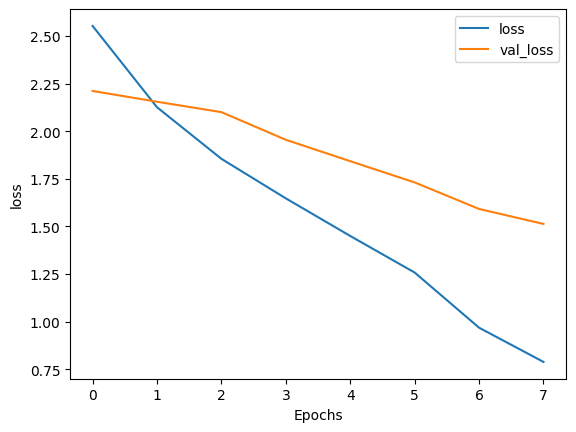

In [ ]:
plot_graphs(history=history, metric='loss')

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


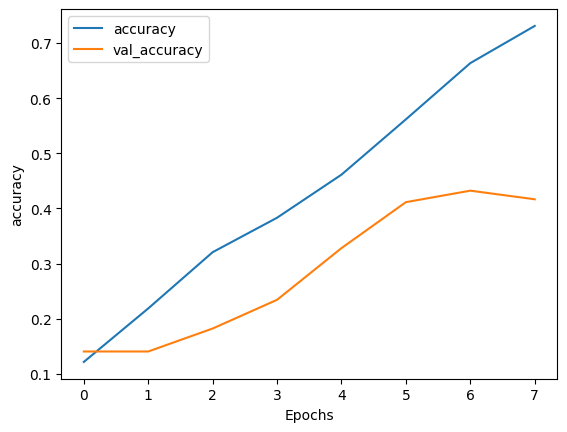

In [ ]:
plot_graphs(history,'accuracy')

In [ ]:
test_df1=test_df.loc[test_df.label==0]

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
test_df1

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,label,tagged_in_context,label_data,multi_label
2,0,Lyndon Johnson <BOS> gets Earl Warren and Sen....,gets Earl Warren and Sen. Richard Russel to j...,0
165,0,"<BOS> In a nation guided by fairness and law, ...","In a nation guided by fairness and law, a per...",4
128,0,"<BOS> Of course, we know what Obama did with h...","Of course, we know what Obama did with his da...",2
347,0,"As every false accusation has fallen away, eve...",one who has exposed a system that threatens h...,3
95,0,<BOS> The enemy is not only at the gates but h...,The enemy is not only at the gates but has no...,0
...,...,...,...,...
318,0,"In a subsequent Facebook post, Lew wrote, “<BO...","My Jewish identity was now public, and a targ...",1
127,0,<BOS> I respectfully suggest that Dr. Fastiggi...,I respectfully suggest that Dr. Fastiggi’s co...,2
480,0,"With the ease of spreading the plague, <BOS> t...",the likelihood that this disease will move to...,0
205,0,There is no low to which the Democrats will no...,strengthening America and protecting Americans,4


In [ ]:
test=test_df1['tagged_in_context']

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
test


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


2      Lyndon Johnson <BOS> gets Earl Warren and Sen....
165    <BOS> In a nation guided by fairness and law, ...
128    <BOS> Of course, we know what Obama did with h...
347    As every false accusation has fallen away, eve...
95     <BOS> The enemy is not only at the gates but h...
                             ...                        
318    In a subsequent Facebook post, Lew wrote, “<BO...
127    <BOS> I respectfully suggest that Dr. Fastiggi...
480    With the ease of spreading the plague, <BOS> t...
205    There is no low to which the Democrats will no...
213    And now <BOS> she has gone full rogue <EOS>, p...
Name: tagged_in_context, Length: 84, dtype: object

In [ ]:
test_label=test_df1.multi_label

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
test_label

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


2      0
165    4
128    2
347    3
95     0
      ..
318    1
127    2
480    0
205    4
213    5
Name: multi_label, Length: 84, dtype: int8

In [ ]:
prediction=model.predict(test)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


3/3 [==============================] - 2s 377ms/step


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


3/3 [==============================] - 1s 358ms/step


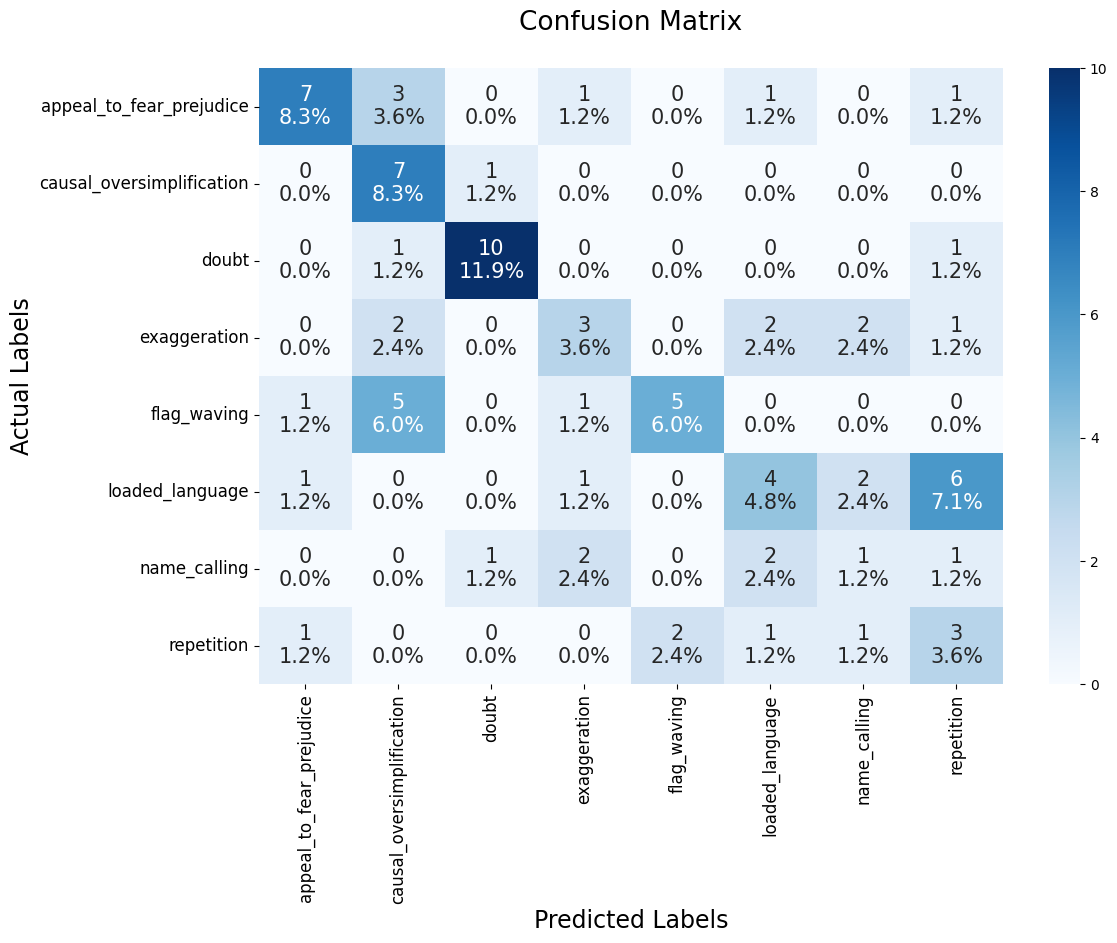

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_cm(model, test_data, test_labels):

    products = ['appeal_to_fear_prejudice','causal_oversimplification','doubt','exaggeration','flag_waving','loaded_language','name_calling', 'repetition']

    # Calculate predictions
    pred = model.predict(test_data)

    # Declaring confusion matrix
    cm = confusion_matrix(test_labels, np.argmax(pred, axis=1))

    # Heat map labels

    group_counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
    group_percentages = ['{0:.1%}'.format(value) for value in cm.flatten()/np.sum(cm)]

    labels = [f"{v2}\n{v3}" for v2, v3 in zip(group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(8,8)

    # Plotting confusion matrix
    plt.figure(figsize=(12,8))

    sns.heatmap(cm, cmap=plt.cm.Blues, annot=labels, annot_kws={"size": 15}, fmt = '',
                xticklabels = products,
                yticklabels = products)

    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12, rotation = 'horizontal')
    plt.title('Confusion Matrix\n', fontsize=19)
    plt.xlabel('Predicted Labels', fontsize=17)
    plt.ylabel('Actual Labels', fontsize=17)

plot_cm(model, test,test_label)


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## First Task Model #2

Build and evaluate at least 2 approaches to classify whether a sentence contains propaganda or not

## Second Model BiLSTM

In [ ]:
#Make a vocab size for the training dataset.
vocab_size = 5000
oov_tok = "<OOV>"
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(np.array(train_df.tagged_in_context))


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#In this function first create text to sequence then add padding into into to make equal size of input size.
sequence_length=30
def word_to_vector(text):
    return pad_sequences(tokenizer.texts_to_sequences(text), maxlen=sequence_length, padding='post', truncating='post')


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
train_padded=word_to_vector(np.array(train_df.tagged_in_context))
test_padded=word_to_vector(np.array(df_test.tagged_in_context))

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
y_train=train_df.label
y_test=df_test.label

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
model = Sequential()
embedding_dim = 16
model.add(Embedding(vocab_size, embedding_dim, input_length=sequence_length))
lstm_out = 64
model.add(Bidirectional(LSTM(lstm_out)))
model.add(Dense(32, kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.25))
model.add(Dense(16, kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.25))
model.add(Dense(8, activation='relu'))

model.add(Dense(1, activation='sigmoid'))

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 16)            80000     
                                                                 
 bidirectional (Bidirectiona  (None, 128)              41472     
 l)                                                              
                                                                 
 dense_2 (Dense)             (None, 32)                4128      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 16)                528       
                                                                 
 dropout_3 (Dropout)         (None, 16)                0         
                                                        

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
import os
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
checkpoint_filepath = os.getcwd()
model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=False, monitor='val_loss', mode='min', save_best_only=True)
callbacks = [EarlyStopping(patience=3), model_checkpoint_callback]

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
history = model.fit(train_padded, y_train, epochs=5, validation_data=(test_padded, y_test), callbacks=callbacks)

Epoch 1/5


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


76/76 [==============================] - ETA: 0s - loss: 1.1397 - accuracy: 0.5866

76/76 [==============================] - 36s 395ms/step - loss: 1.1397 - accuracy: 0.5866 - val_loss: 0.9191 - val_accuracy: 0.6259
Epoch 2/5
76/76 [==============================] - ETA: 0s - loss: 0.7529 - accuracy: 0.7183

76/76 [==============================] - 19s 249ms/step - loss: 0.7529 - accuracy: 0.7183 - val_loss: 0.7023 - val_accuracy: 0.7000
Epoch 3/5
76/76 [==============================] - ETA: 0s - loss: 0.4504 - accuracy: 0.8550

76/76 [==============================] - 19s 245ms/step - loss: 0.4504 - accuracy: 0.8550 - val_loss: 0.6677 - val_accuracy: 0.6966
Epoch 4/5
76/76 [==============================] - 2s 25ms/step - loss: 0.2859 - accuracy: 0.9176 - val_loss: 0.9757 - val_accuracy: 0.6690
Epoch 5/5
76/76 [==============================] - 2s 26ms/step - loss: 0.1842 - accuracy: 0.9519 - val_loss: 1.0216 - val_accuracy: 0.6741


In [ ]:
metrics_df = pd.DataFrame(history.history)
print(metrics_df)

       loss  accuracy  val_loss  val_accuracy
0  1.139733  0.586578  0.919113      0.625862
1  0.752850  0.718310  0.702322      0.700000
2  0.450384  0.855012  0.667745      0.696552
3  0.285940  0.917564  0.975662      0.668966
4  0.184150  0.951947  1.021621      0.674138


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


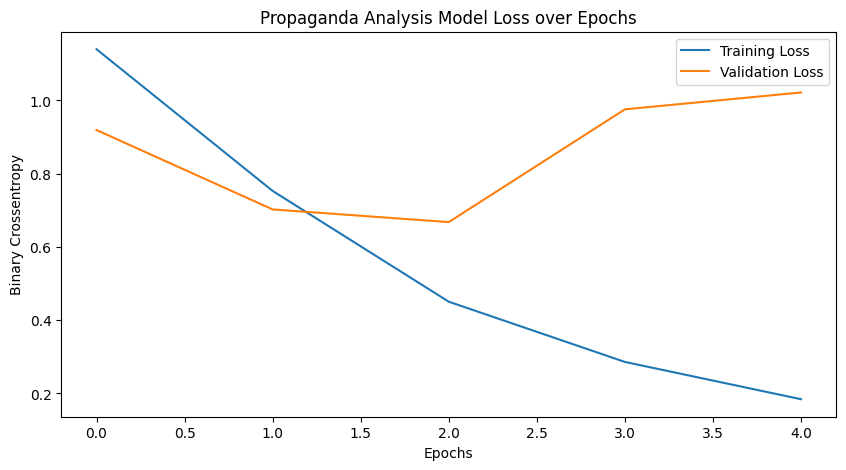

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(metrics_df.index, metrics_df.loss)
plt.plot(metrics_df.index, metrics_df.val_loss)
plt.title('Propaganda Analysis Model Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Binary Crossentropy')
plt.legend(['Training Loss', 'Validation Loss'])
plt.show()

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


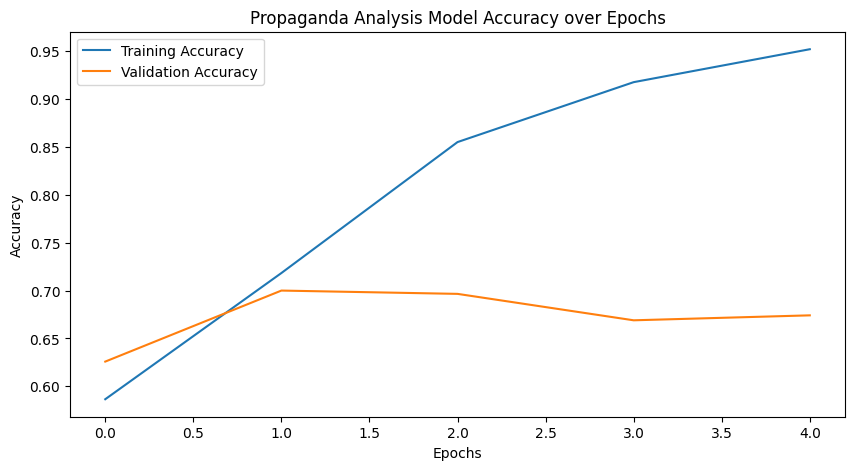

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(metrics_df.index, metrics_df.accuracy)
plt.plot(metrics_df.index, metrics_df.val_accuracy)
plt.title('Propaganda Analysis Model Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.show()

In [ ]:
test_model=word_to_vector(test_df.tagged_in_context)
test_labels=test_df.label

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
from sklearn.metrics import confusion_matrix
predic=model.predict(test_model)
res=[]
for i in predic:
    if i>0.5:
        res.append(1)
    else:
        res.append(0)
result = confusion_matrix(test_labels, res)
print(result)


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


6/6 [==============================] - 1s 4ms/step
[[63 21]
 [38 52]]


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


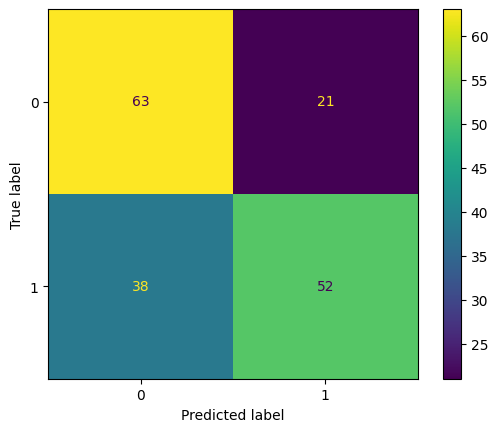

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(test_labels, res)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Second Task Model #2


Given a snippet or span of text which is known to contain propaganda, build and evaluate at least
2 approaches to classifying the propaganda technique which has been used

In [ ]:
model = Sequential()
embedding_dim = 16
model.add(Embedding(vocab_size, embedding_dim, input_length=sequence_length))
lstm_out = 64
model.add(Bidirectional(LSTM(lstm_out)))
model.add(Dense(32, kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.25))
model.add(Dense(16, kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.25))

model.add(Dense(9, activation='softmax'))

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
train_padded=word_to_vector(np.array(train_df1['tagged_in_context']))
test_padded=word_to_vector(np.array(df_test1['tagged_in_context']))

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
y_train=train_df1.multi_label
y_test=df_test1.multi_label

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
y_test

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


1      1
2      0
4      8
5      6
6      5
      ..
569    4
571    4
572    5
578    4
579    1
Name: multi_label, Length: 279, dtype: int8

In [ ]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
history = model.fit(train_padded,y_train, epochs=8, validation_data=(test_padded, y_test), callbacks=callbacks)

Epoch 1/8


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


39/39 [==============================] - 13s 222ms/step - loss: 2.7324 - accuracy: 0.1259 - val_loss: 2.5645 - val_accuracy: 0.1470
Epoch 2/8
39/39 [==============================] - 3s 84ms/step - loss: 2.4793 - accuracy: 0.1169 - val_loss: 2.3815 - val_accuracy: 0.1541
Epoch 3/8
39/39 [==============================] - 3s 71ms/step - loss: 2.3524 - accuracy: 0.1415 - val_loss: 2.3032 - val_accuracy: 0.1254
Epoch 4/8
39/39 [==============================] - 2s 63ms/step - loss: 2.2805 - accuracy: 0.1251 - val_loss: 2.2348 - val_accuracy: 0.1111
Epoch 5/8
39/39 [==============================] - 3s 68ms/step - loss: 2.2178 - accuracy: 0.1504 - val_loss: 2.1865 - val_accuracy: 0.1577
Epoch 6/8
39/39 [==============================] - 2s 63ms/step - loss: 2.0810 - accuracy: 0.2486 - val_loss: 2.2129 - val_accuracy: 0.1900
Epoch 7/8
39/39 [==============================] - 2s 46ms/step - loss: 1.8928 - accuracy: 0.2805 - val_loss: 2.2795 - val_accuracy: 0.1756
Epoch 8/8
39/39 [===========

In [ ]:
metrics_df = pd.DataFrame(history.history)
print(metrics_df)

       loss  accuracy  val_loss  val_accuracy
0  2.732431  0.125920  2.564467      0.146953
1  2.479255  0.116926  2.381500      0.154122
2  2.352438  0.141455  2.303183      0.125448
3  2.280497  0.125102  2.234813      0.111111
4  2.217758  0.150450  2.186455      0.157706
5  2.081002  0.248569  2.212903      0.189964
6  1.892834  0.280458  2.279473      0.175627
7  1.729150  0.333606  2.366003      0.232975


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


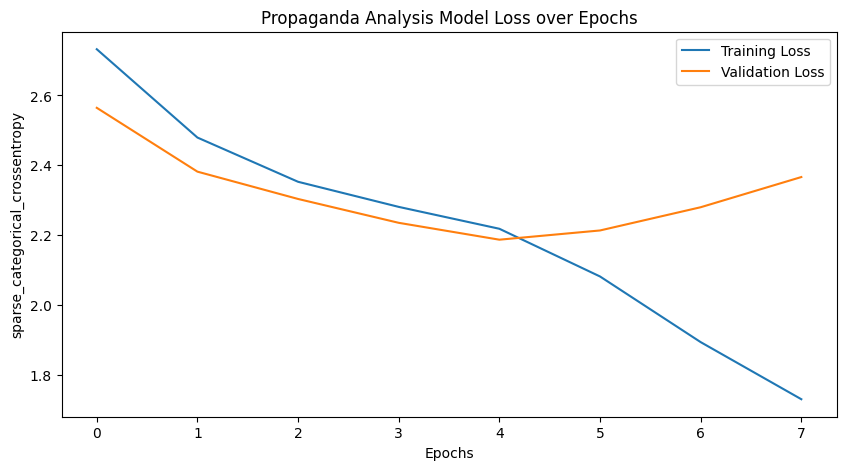

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(metrics_df.index, metrics_df.loss)
plt.plot(metrics_df.index, metrics_df.val_loss)
plt.title('Propaganda Analysis Model Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('sparse_categorical_crossentropy')
plt.legend(['Training Loss', 'Validation Loss'])
plt.show()

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


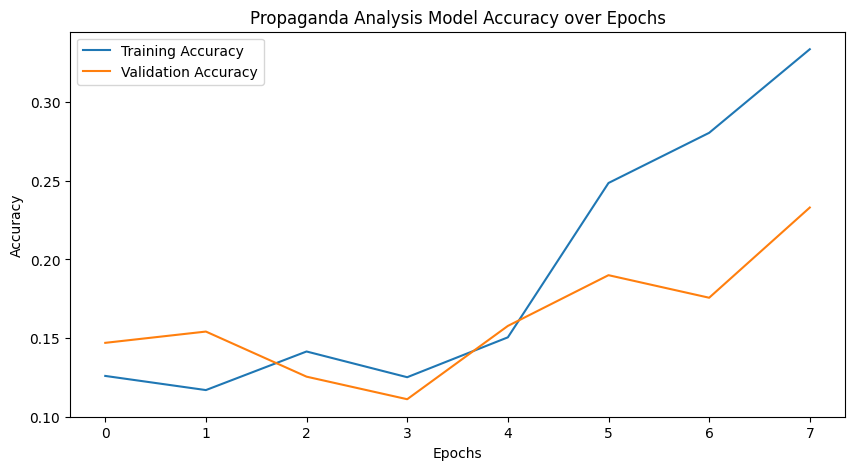

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(metrics_df.index, metrics_df.accuracy)
plt.plot(metrics_df.index, metrics_df.val_accuracy)
plt.title('Propaganda Analysis Model Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.show()

In [ ]:
test_model=word_to_vector(test_df1['tagged_in_context'])
test_labels=test_df1.multi_label

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


3/3 [==============================] - 1s 6ms/step


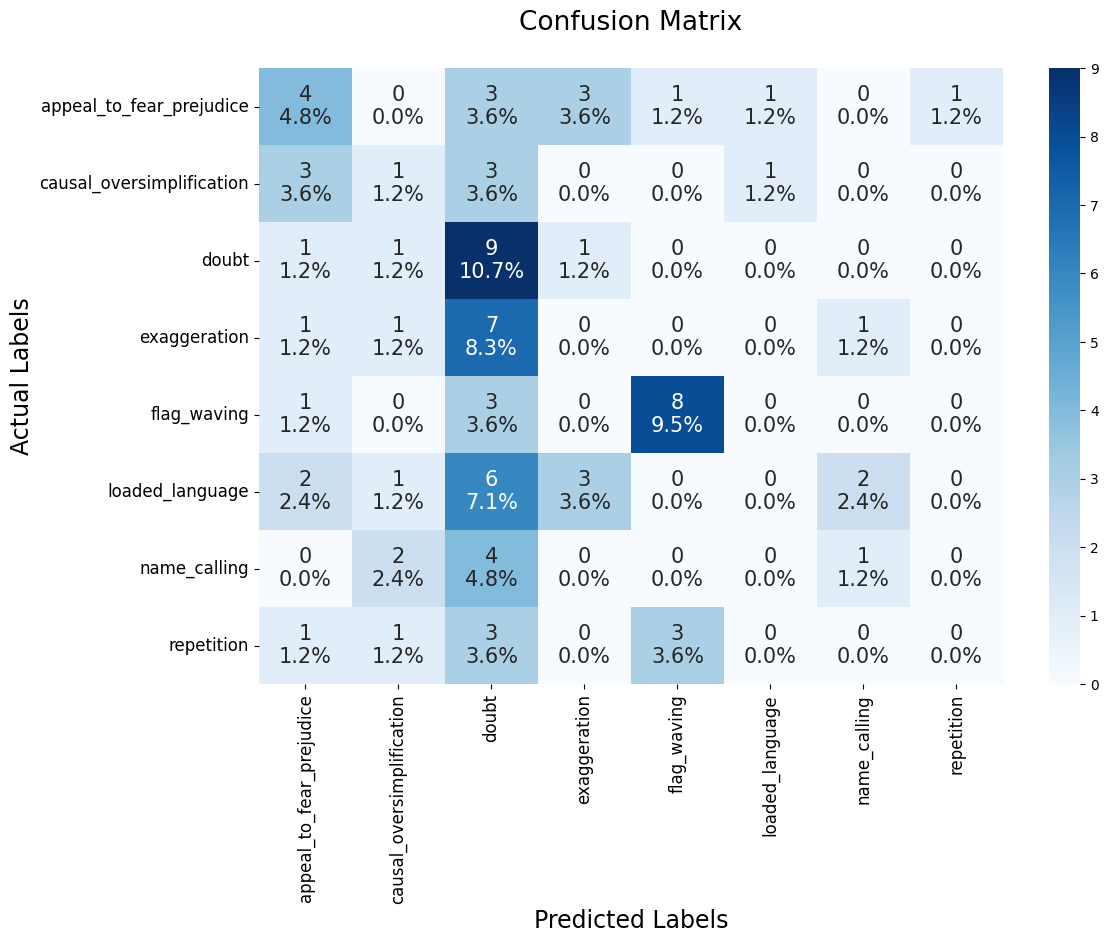

In [ ]:
plot_cm(model, test_model,test_labels)
